# Manual Feature Engineering on the Retail Dataset

In this notebook we will work with a dataset of online retail transactions. This data is originally from [the UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/online+retail#) and is a great example of real-world time-series data. Our objective will be to develop a model that can predict the spending of a customer in the next month given the past spending data for that customer. 

In the automated feature engineering notebook, we saw how to solve this problem using Featuretools in a machine learning pipeline. We were able to build a model that ourperformed the baseline in terms of our metrics (F1 and ROC AUC). In this notebook, we'll approach the problem completely by hand, relying on our own abilities as data scientists to develop a set of valid, relevant features for the prediction problem. 

In [1]:
# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

First let's load in the raw data and take a look. We'll apply the same data formatting principles 

In [2]:
csv_s3 = "s3://featurelabs-static/online-retail-logs.csv"
data = pd.read_csv(csv_s3, parse_dates=["order_date"])

# Convert to dollars
data['price'] = data['price'] * 1.65
data['total'] = data['price'] * data['quantity']

# Restrict data to 2011
data = data[data['order_date'].dt.year == 2011]

# drop the duplicates
data = data.drop_duplicates()

# drop rows with null customer id
data = data.dropna(axis=0)

data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.175
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.325
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.625


# Load in Prediction Problem

We already created the prediction problem in the automated feature engineering notebook. The objective is to predict the total spending of customers in the next month. Instead of forecasting the amount, we decided to group customers into a segment that spends more than \$500 and a segment spending less. 

Each customer is represented in the labels multiple times, once for each month that we want to predict. Using customers multiple times allows us to construct more labelled training examples. However, it also means that we must be careful in the data we use.

In [3]:
labels = pd.read_csv('../input/labels.csv', index_col=0)
labels.head()

,customer_id,cutoff_time,total,label
0,12352.0,2011-03-01,502.7220,1
1,12383.0,2011-03-01,589.1655,1
2,12388.0,2011-03-01,347.9850,0
3,12395.0,2011-03-01,538.7250,1
4,12415.0,2011-03-01,27320.9310,1


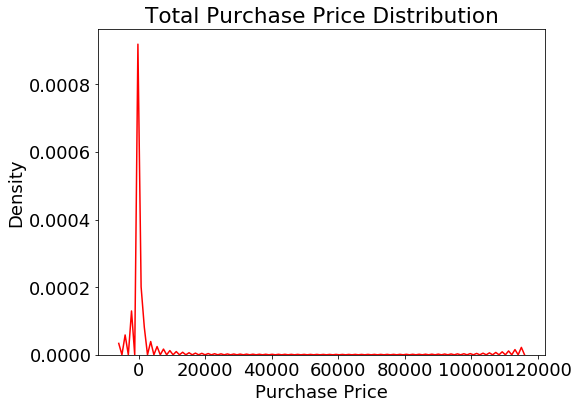

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['font.size'] = 18
from IPython.core.pylabtools import figsize
figsize(8, 6)

# KDE plot of total price
sns.distplot(labels['total'], hist=False, color = 'red');
plt.title('Total Purchase Price Distribution');
plt.xlabel('Purchase Price'); plt.ylabel('Density');

In [5]:
def ecdf(a):
    x = np.sort(a)
    y = np.arange(len(x)) / float(len(x))
    return x, y

The 90th percentile is at $792.76


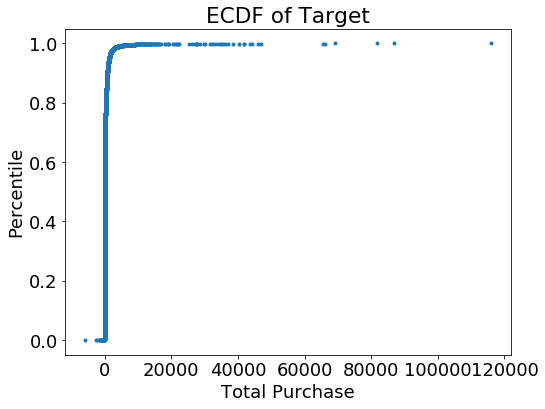

In [6]:
x, y = ecdf(labels['total'])
plt.plot(x, y, '.');
plt.xlabel('Total Purchase'); plt.ylabel('Percentile'); plt.title('ECDF of Target');
print(f'The 90th percentile is at ${round(x[np.where(y > 0.9)[0][0]], 2)}')

In [7]:
print(f'There are {len(data)} observations in the final data with {data["customer_id"].nunique()} unique customers.')
print(f'There are {len(labels)} labels.')

There are 375250 observations in the final data with 4244 unique customers.
There are 28133 labels.


# Feature Engineering

Once we have our machine learning task, we need to figure out how to get the data into a format for training a model. For each label (customer - month) we are going to need one row of data, with the columns forming the features. The tricky part is that we must be sure to not use any future data for predicting in a given month. As a first pass, we can limit ourselves to trying to build a model to make predictions for December 2011. Since this is the last month in the dataset, we should have the most data and be able to build an accurate model. 

Feature engineering will require us to aggregate information that is no the purchase level into information on the customer level. We need to try and create features that are relevant for predicting how much a customer will spend in the future. We can do this by incorporating domain knowledge and building features either one at a time, or in groups using multiple aggregations at once.

## Enriching the data

One of the simplest feature engineering steps is to extract information from the original data such as by finding the `weekday`, `month`, `hour`, and `minute` of the purchase. (These are referred to as transform primitives in Featuretools).

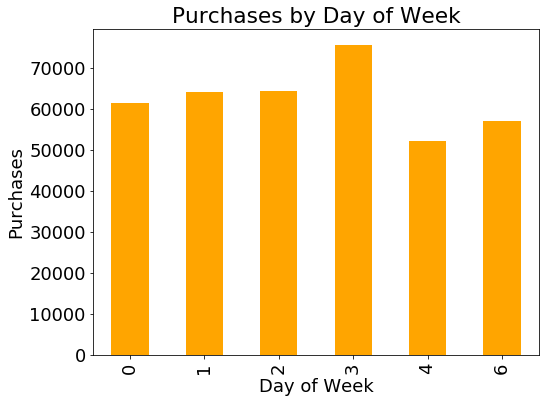

In [8]:
data['weekday'] = data['order_date'].dt.weekday
data['month'] = data['order_date'].dt.month
data['minute'] = data['order_date'].dt.minute
data['hour'] = data['order_date'].dt.hour
data['date_only'] = data['order_date'].dt.date

# Plot of purchases by day of week
data['weekday'].value_counts().sort_index().plot.bar(color = 'orange');
plt.title('Purchases by Day of Week'); plt.ylabel('Purchases'); plt.xlabel('Day of Week');

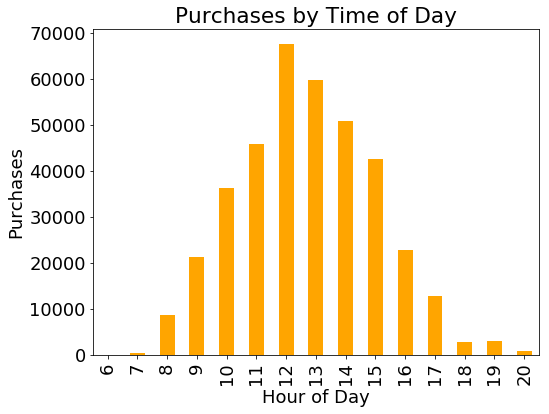

In [9]:
data['hour'].value_counts().sort_index().plot.bar(color = 'orange');
plt.title('Purchases by Time of Day'); plt.ylabel('Purchases'); plt.xlabel('Hour of Day');

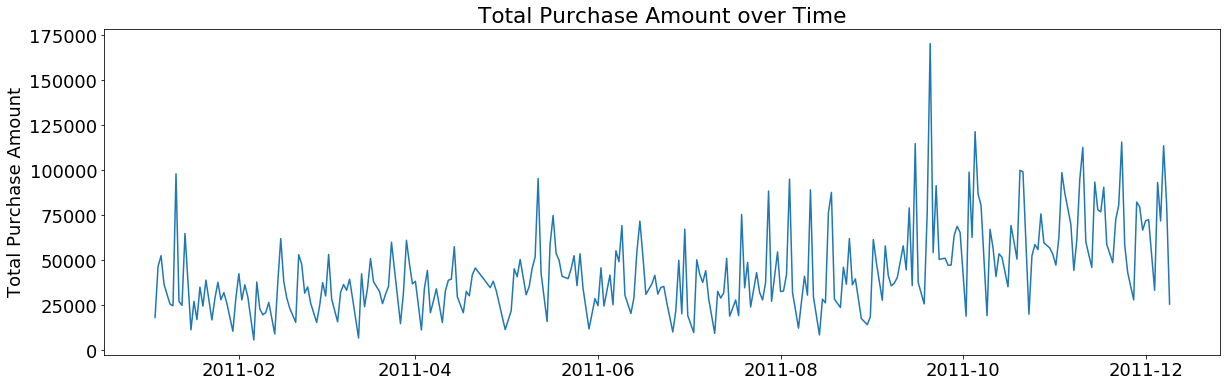

In [10]:
figsize(20, 6)
trends = data.groupby('date_only')['total'].sum()
trends.plot()
plt.title('Total Purchase Amount over Time'); plt.xlabel(''); plt.ylabel('Total Purchase Amount');

We can't yet use these features for machine learning since they are still on a _purchase_ level. We need features on a _customer_ level. 

### Subset to Valid Data

Before we go any further, we are going to want to subset to the valid data. Our first goal is to predict only December spending, so for our training data, we'll limit ourselves to data before November while our testing data will use only information in November. The training labels are for customer - months from November and before, and the testing labels are those from December. This is the same method we used for assessing the Featuretools model. 

To summarize if we are making predictions for December 2011:

* Training data: anything from before November 2011
* Testing data: data from November 2011
* Training labels: customer - months from before December 2011
* Testing labels: customer spending in December 2011

The following code subsets the data.

In [47]:
labels['cutoff_time'] = pd.to_datetime(labels['cutoff_time'])
labels['month'] = labels['cutoff_time'].dt.month

In [48]:
train = data[data['month'] < 11]
test = data[data['month'] == 11]
train_labels = labels.loc[labels['month'] < 12, ['customer_id', 'label', 'month']]
test_labels = labels.loc[labels['month'] == 12, ['customer_id', 'label', 'month']]

Let's quickly look at the results of an informed baseline guess for December. This guess comes from using the spending of the customer in November (the previous month) as the prediction in the next month.

In [49]:
def informed_baseline(month_number, threshold = 500):
    """Calculate an informed baseline for a given month. 
    The informed baseline is guessing the previous month's spending
    for the next month. The probability is assessed by dividing
    the previous month's total by the threshold and setting
    any values greater than 1 to 1."""
    
    # Subset to the months
    month = labels[labels['month'] == month_number]
    previous_month = labels[labels['month'] == (month_number - 1)]
    
    previous_month = previous_month.rename(columns = {'total': 'previous_total'})

    # Merge the current month with the previous month
    month = month.merge(previous_month[['customer_id', 'previous_total']], on = 'customer_id', how = 'left')
    
    month['previous_total'] = month['previous_total'].fillna(0)
    month['probability'] = month['previous_total'] / threshold
    
    # Set probabilities greater than 1 equal to 1
    month.loc[month['probability'] > 1, 'probability'] = 1
    
    # Make the predicted label
    month['prediction'] = (month['previous_total'] > threshold).astype(int)
    
    print('Precision: {:.5f}.'.format(precision_score(month['label'], month['prediction'])))
    print('Recall: {:.5f}.'.format(recall_score(month['label'], month['prediction'])))
    print('F1 Score: {:.5f}.'.format(f1_score(month['label'], month['prediction'])))
    print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(month['label'], month['probability'])))
    
    return month

In [50]:
december_informed = informed_baseline(12)

Precision: 0.21606.
Recall: 0.57547.
F1 Score: 0.31416.
ROC AUC Score: 0.69502.


This gives us a target to beat: if our model is not better than the informed baseline, then we are better off using the baseline instead of machine learning! In the automated feature engineering notebook, the best model was able to score __0.81378 ROC AUC__, significantly better than the baseline.

## Simple Feature Engineering

As a first pass at feature engineering, we can group by the month and the customer and calculate numerical aggregations of the purchase data. We'll then join the data for one month to the prediction for the following month to ensure that our data comes before our labels.

In [51]:
train_agg = train.groupby(['customer_id', 'month']).agg(['mean', 'max', 'min', 'sum', 'count'])

new_cols = []
for col in train_agg.columns.levels[0]:
    for stat in train_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
train_agg.columns = new_cols
train_agg.head()

quantity-mean  quantity-max  quantity-min  quantity-sum  \
customer_id month                                                            
12346.0     1           0.000000         74215        -74215             0   
12347.0     1          10.862069            24             3           315   
            4          20.125000           240             3           483   
            6          10.888889            36             2           196   
            8          12.590909            36             3           277   

                   quantity-count  price-mean  price-max  price-min  \
customer_id month                                                     
12346.0     1                   2    1.716000     1.7160     1.7160   
12347.0     1                  29    4.163121    21.0375     0.6930   
            4                  24    4.282437    21.0375     0.4125   
            6                  18    4.915167    16.4175     0.4950   
            8                  22    5.118000    21.0375     0.9075   

                   price-sum  price-count     ...      minute-mean  \
customer_id month                             ...                    
12346.0     1         3.4320            2     ...              9.0   
12347.0     1       120.7305           29     ...             30.0   
            4       102.7785           24     ...             43.0   
            6        88.4730           18     ...              1.0   
            8       112.5960           22     ...             48.0   

                   minute-max  minute-min  minute-sum  minute-count  \
customer_id month                                                     
12346.0     1              17           1          18             2   
12347.0     1              30          30         870            29   
            4              43          43        1032            24   
            6               1           1          18            18   
            8              48          48        1056            22   

                   hour-mean  hour-max  hour-min  hour-sum  hour-count  
customer_id month                                                       
12346.0     1           10.0        10        10        20           2  
12347.0     1           14.0        14        14       406          29  
            4           10.0        10        10       240          24  
            6           13.0        13        13       234          18  
            8            8.0         8         8       176          22  

[5 rows x 30 columns]

Since we're aggregating for the previous month, we need to add one to the month and join with the labels. 

In [52]:
train_agg.reset_index(inplace = True)
train_agg['month'] = train_agg['month'] + 1
train_agg.set_index(['customer_id', 'month'], inplace = True)

In [53]:
train_data = train_labels.merge(train_agg, on = ['customer_id', 'month'], how = 'left')

Now the stats for the _previous_ month are associated with the label. So the stats for June are going to be used to predict the label for July.

In [54]:
test_agg = test.groupby(['customer_id', 'month']).agg(['mean', 'max', 'min', 'sum', 'count'])

new_cols = []
for col in test_agg.columns.levels[0]:
    for stat in test_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
test_agg.columns = new_cols
test_agg.reset_index(inplace = True)
test_agg['month'] = test_agg['month'] + 1
test_agg.set_index(['customer_id', 'month'], inplace = True)
test_data = test_labels.merge(test_agg, on = ['customer_id', 'month'], how = 'left')

The same thing applies for the test data. The information in each row comes from November because the label is for December. 

In [55]:
test_data.head()

,customer_id,label,month,quantity-mean,quantity-max,quantity-min,quantity-sum,quantity-count,price-mean,price-max,...,minute-mean,minute-max,minute-min,minute-sum,minute-count,hour-mean,hour-max,hour-min,hour-sum,hour-count
0,12347.0,0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12358.0,1,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12359.0,0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12362.0,1,12,10.684211,36.0,-3.0,203.0,19.0,6.302132,24.75,...,14.578947,55.0,7.0,277.0,19.0,9.789474,14.0,9.0,186.0,19.0
4,12364.0,1,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now let's train and test a model.

In [56]:
feature_names = train_data.drop(columns = ['customer_id', 'label', 'month']).columns

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_ready = pipeline.fit_transform(train_data.drop(columns = ['customer_id', 'label', 'month']))
test_ready = pipeline.transform(test_data.drop(columns = ['customer_id', 'label', 'month']))

In [57]:
model = RandomForestClassifier(n_estimators=1000, n_jobs = -1, random_state=50)
model.fit(train_ready, train_data['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [58]:
predictions = model.predict(test_ready)

predictions = model.predict(test_ready)
probs = model.predict_proba(test_ready)[:, 1]

# Calculate metrics
p = precision_score(test_labels['label'], predictions)
r = recall_score(test_labels['label'], predictions)
f = f1_score(test_labels['label'], predictions)
auc = roc_auc_score(test_labels['label'], probs)

print(f'Precision: {round(p, 5)}')
print(f'Recall: {round(r, 5)}')
print(f'F1 Score: {round(f, 5)}')
print(f'ROC AUC: {round(auc, 5)}')

# Feature importances
fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

Precision: 0.3653
Recall: 0.25157
F1 Score: 0.29795
ROC AUC: 0.75533


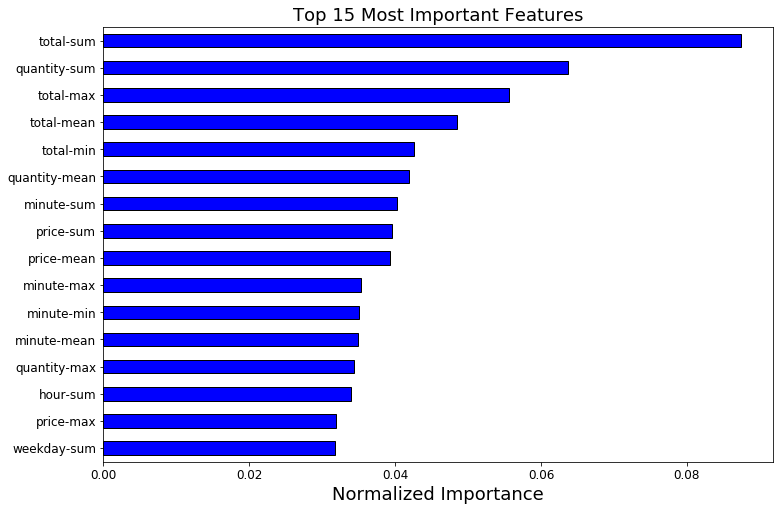

In [59]:
from utils import plot_feature_importances
norm_fi = plot_feature_importances(fi)

Our first attempt at a model does slightly better than the baseline but performs worse in terms of F1 score. The most important features do make sense though because the total spent previously or the total quantity purchased previously are good indicators of how much a customer will purchase in the future. 

Let's take this code and use it in a function so we can make predictions for any month.

### Function for Aggregating and Predicting Monthly Data

In [64]:
def predict_month(month):
    train = data[data['month'] < (month - 1)]
    test = data[data['month'] == (month - 1)]
    train_labels = labels.loc[labels['month'] < month, ['customer_id', 'label', 'month']]
    test_labels = labels.loc[labels['month'] == month, ['customer_id', 'label', 'month']]
    
    train_agg = train.groupby(['customer_id', 'month']).agg(['mean', 'max', 'min', 'sum', 'count'])

    new_cols = []
    for col in train_agg.columns.levels[0]:
        for stat in train_agg.columns.levels[1]:
            new_cols.append(f'{col}-{stat}')

    train_agg.columns = new_cols

    train_data = train_labels.merge(train_agg, on = ['customer_id', 'month'], how = 'left').fillna(0)

    feature_names = train_data.drop(columns = ['customer_id', 'label', 'month']).columns
    
    test_agg = test.groupby(['customer_id', 'month']).agg(['mean', 'max', 'min', 'sum', 'count'])

    new_cols = []
    for col in test_agg.columns.levels[0]:
        for stat in test_agg.columns.levels[1]:
            new_cols.append(f'{col}-{stat}')

    test_agg.columns = new_cols
    test_agg.reset_index(inplace = True)
    test_agg['month'] = test_agg['month'] + 1
    test_agg.set_index(['customer_id', 'month'], inplace = True)
    test_data = test_labels.merge(test_agg, on = ['customer_id', 'month'], how = 'left').fillna(0)

    pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                          ('scaler', MinMaxScaler())])

    # Fit and transform training data
    train_ready = pipeline.fit_transform(train_data.drop(columns = ['customer_id', 'label', 'month']))
    test_ready = pipeline.transform(test_data.drop(columns = ['customer_id', 'label', 'month']))

    model = RandomForestClassifier(n_estimators=1000, n_jobs = -1, random_state=50)
    model.fit(train_ready, train_data['label'])

    predictions = model.predict(test_ready)

    predictions = model.predict(test_ready)
    probs = model.predict_proba(test_ready)[:, 1]

    # Calculate metrics
    p = precision_score(test_labels['label'], predictions)
    r = recall_score(test_labels['label'], predictions)
    f = f1_score(test_labels['label'], predictions)
    auc = roc_auc_score(test_labels['label'], probs)

    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    return fi


In [65]:
july_fi = predict_month(7)

Precision: 0.36229
Recall: 0.43653
F1 Score: 0.39596
ROC AUC: 0.66162


In [66]:
_ = informed_baseline(7)

Precision: 0.41784.
Recall: 0.39644.
F1 Score: 0.40686.
ROC AUC Score: 0.64365.


In [67]:
print('Model Results\n')
august_fi = predict_month(8)

print('Baseline Results\n')
_ = informed_baseline(8)

Model Results

Precision: 0.34909
Recall: 0.42857
F1 Score: 0.38477
ROC AUC: 0.66284
Baseline Results

Precision: 0.40089.
Recall: 0.40179.
F1 Score: 0.40134.
ROC AUC Score: 0.66544.


It should not be that surprising our model doesn't do better than the baseline. Our aggregations are _only using the past month_ and therefore are essentially doing the same process as the informed guess. In order to try and perform better, we should make features for each label using all the previous data for the customer. That means for the June labels, we do not just use information from May, but from the entire sequence of data for the customer. 

## Including More Information

We can rewrite the code to aggregate information over all the previous months for each label. 

In [106]:
def predict_month_expanded(month, return_probs = False):
    
    train = data[data['month'] < (month - 1)]
    test = data[data['month'] < month ]
    
    # Training labels are from all previous months
    train_labels = labels.loc[labels['month'] < month, ['customer_id', 'label', 'month']]
    
    # Test labels are from a single month
    test_labels = labels.loc[labels['month'] == month, ['customer_id', 'label', 'month']]
    
    # Iterate through each month
    for i, train_month in enumerate(train_labels['month'].unique()):

        # Training data is from all months before the label
        train_agg = train.loc[train['month'] < train_month].groupby(['customer_id']).agg(['mean', 'max', 'min', 'sum', 'count'])

        # Rename the columns
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        # Set the month for joining to the labels
        train_agg['month'] = train_month
        
        # Create a dataframe of the training data
        if i == 0:
             all_train_data = train_agg.copy()
                
        else:
            all_train_data = all_train_data.append(all_train_data)
            
    # all_train_data.set_index(['customer_id', 'month'], inplace = True)
    # Join with the labels on the customer and month
    all_train_data = train_labels.merge(all_train_data, on = ['customer_id', 'month'], how = 'left')
        
    feature_names = all_train_data.drop(columns = ['customer_id', 'label', 'month']).columns
    
    # Test data is already subsetted to all previous months
    test_agg = test.groupby(['customer_id']).agg(['mean', 'max', 'min', 'sum', 'count'])
    
    # Rename the columns
    new_cols = []
    for col in test_agg.columns.levels[0]:
        for stat in test_agg.columns.levels[1]:
            new_cols.append(f'{col}-{stat}')

    test_agg.columns = new_cols
    # test_agg.set_index(['customer_id', 'month'], inplace = True)
    test_data = test_labels.merge(test_agg, on = ['customer_id'], how = 'left')

    pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                          ('scaler', MinMaxScaler())])

    # Imputer the missing values and scale
    train_ready = pipeline.fit_transform(all_train_data.drop(columns = ['customer_id', 'label', 'month']))
    test_ready = pipeline.transform(test_data.drop(columns = ['customer_id', 'label', 'month']))

    # Machine learning modeling
    model = RandomForestClassifier(n_estimators=1000, n_jobs = -1, random_state=50)
    model.fit(train_ready, all_train_data['label'])

    # Predictions
    predictions = model.predict(test_ready)
    predictions = model.predict(test_ready)
    probs = model.predict_proba(test_ready)[:, 1]

    # Calculate metrics
    p = precision_score(test_labels['label'], predictions)
    r = recall_score(test_labels['label'], predictions)
    f = f1_score(test_labels['label'], predictions)
    auc = roc_auc_score(test_labels['label'], probs)

    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi

In [101]:
june_fi = predict_month_expanded(6)

Precision: 0.5124
Recall: 0.43662
F1 Score: 0.47148
ROC AUC: 0.76242


In [102]:
september_fi = predict_month_expanded(9)

Precision: 0.46912
Recall: 0.50877
F1 Score: 0.48814
ROC AUC: 0.76909


In [103]:
december_fi = predict_month_expanded(12)

Precision: 0.19911
Recall: 0.70126
F1 Score: 0.31015
ROC AUC: 0.80234


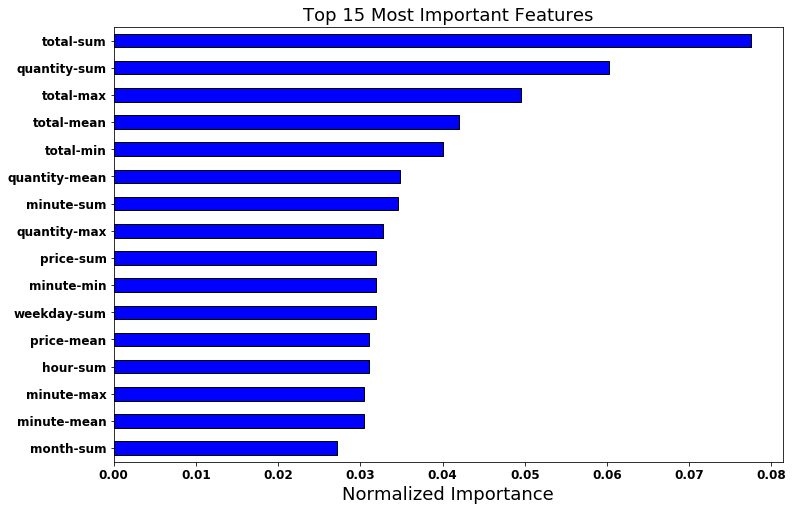

In [104]:
_ = plot_feature_importances(june_fi)

We can conclude from the metrics that manual feature engineering now outperforms the baseline if we use all of the previous information. Looking at the feature importances, they seem to make sense in the domain of the problem. However, I'm not entirely convinced that all of the data is allowable for this problem. Taking on this problem by hand introduces many opportunities for error. Companies routinely struggle with the issue of using only valid data and often will design a model that does well in development but then fails in deployment because it was trained on data that won't actually be available in the real world. 

Featuretools can automatically handle the cutoff times for us, ensuring that all of our features are built using valid data. If the method exists and can be used to safely build features, then what's the downside to using it as opposed to doing everything by hand? Finally, let's take a look at a comparison between manual and automated feature engineering performance.

# Comparison to Automated Feature Engineering

To compare the performance of Automated Feature Engineering, the baseline model, and manual feature engineering, we can plot the ROC AUC curves for each month. A ROC AUC curve that is strictly higher than the curve for another classifier indicates a better classifier. 

In [111]:
%%capture

for month in range(4, 13):
    _, probs = predict_month_expanded(month, True)
    temp_df = pd.DataFrame({'Manual': probs, 'month': month})
    
    if month == 4:
        probs_df = temp_df.copy()
    
    else:
        probs_df = probs_df.append(temp_df)
        
probs_df.head()

In [113]:
probs_df.shape

(26851, 2)

In [114]:
labels.shape

(28133, 5)

In [ ]:
labels.loc-l

In [116]:
labels['month'].unique()

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

## Normalizing Data

It can be a little easier to use our data if we have it in normalized tables where each row represents a unique observations. We'll create 4 tables of information:

* customers: each customer (`customter_id`) will have one row
* products: each product (`product_id`) will have one row
* orders: each invoice (`order_id`) will have one row
* purchases: each purchased item will have one row

The purchases dataframe is the child of all the other dataframes. The `customers` dataframe is where we will make our features for the prediction problem. Hence to make features, we will have to aggregate the purchase data for each customer. Let's start by breaking the data into multiple dataframes. We'll have to keep separate tables in order to not mix the training and testing data.a

### Orders

First we'll create a table of just the orders. Each order is uniquely identified by the `order_id` and also has a date, customer, and country. We can also add a `total_price` for the order by summing up all of the products associated with that order.

In [27]:
orders = pd.DataFrame(data.groupby(['order_id', 'date_only', 'customer_id', 'country'])['price'].sum().reset_index())
orders.head()

,order_id,date_only,customer_id,country,price
0,539993,2011-01-04,13313.0,United Kingdom,62.7660
1,540001,2011-01-04,18097.0,United Kingdom,43.9395
2,540002,2011-01-04,16656.0,United Kingdom,26.1030
3,540003,2011-01-04,16875.0,United Kingdom,216.6450
4,540004,2011-01-04,13094.0,United Kingdom,1.7490


We should make sure that this table is normalized by checking that there are no duplicated order ids.

In [28]:
print(f'There are {orders["order_id"].nunique()} unique orders and {np.sum(orders["order_id"].duplicated())} duplicated orders.')

There are 20482 unique orders and 0 duplicated orders.


This tells us we made an error in creating the table.

In [29]:
orders[orders.duplicated(subset = 'order_id', keep = False)].head()

,order_id,date_only,customer_id,country,price


The problem is that orders do not all have the same date. Therefore when we made the orders table, we should not have grouped by the date time. However, we can group by just the `date_only` and see if all orders are made on the same day. 

In [30]:
orders = pd.DataFrame(data.groupby(['order_id', 'date_only', 'customer_id', 'country'])['total_price'].sum().reset_index())
print(f'There are {orders["order_id"].nunique()} unique orders and {np.sum(orders["order_id"].duplicated())} duplicated orders.')

KeyError: 'Column not found: total_price'

Now we are good to go without the duplicated orders. We can use this table to create features, for example by finding the total number of orders of each customer or the most common day on which they make purchases.

### Customers

Each customer is uniquely identified by the `customer_id`. This table will be where we make all the features since we are predicting based on each customer.

In [ ]:
len(labels)

In [ ]:
customers = pd.DataFrame(labels.index.unique())
customers.head()

### Products

Each product is identified by the `product_id`. The unit price might not stay the same so we cannot associate this with each product.

In [ ]:
products = pd.DataFrame(data['product_id'].unique(), columns = ['product_id'])
products.head()

### Purchases

Each purchase is idenitifed by combination of the `order_id`, the `customer_id`, and the `product_id`. The purchases data is already saved as the data table.

In [ ]:
purchases = data.copy()

# Baselines

Before we get started with the real feature engineering and modeling, we should establish a naive baseline model. This will let us measure the effectiveness of any feature engineering. For a regression problem, a naive baseline can be simply the average value of the train labels. 

## Metric 

Since this is a regression problem dealing with a quantity that has a real meaning, we want to use a metric that is easily understandable. The __Median Absolute Error__ (MAE) for this problem shows the median dollar amount that our forecasts are off. This can be calculated as simply the median of the absolute value of the prediction minus the true value:

$$\text{MAE} = \text{median(abs(prediction - true value))}$$

The median absolute error is a better metric than the mean absolute error since the mean will be unduly influenced by outliers (and we saw that there are a number of outliers in the target).

### Naive Baseline

Below we establish a naive baseline by guessing the value of the test label is the average value on the training labels.

In [ ]:
from sklearn.metrics import f1_score

print(f'Baseline Guess F1 Score = {f1_score(test_labels, [0 for _ in range(len(test_labels))])}.') 

In [ ]:
f1_score(test_labels, [np.random.randint(0, 2, 1)[0] for _ in range(len(test_labels))])

### More Informed Baseline

A slightly better estimate would be to guess that customers will spend as much in the next month as they spent in the previous month. We can figure this out by using the last thirty days of the purchase data.

In [ ]:
thirty_day_totals = []
prediction_point = pd.datetime(2011, 10, 1)

# Iterate through each customer
for customer_id, customer_info in labels.iterrows():
    
    # Subset the data to after the prediction point
    subset = data.loc[(data['date'] > prediction_point) & (data['customer_id'] == customer_id), :].copy()
    
    # Add the number of unique orders in the month to a list
    thirty_day_totals.append(subset['total_price'].sum())

In [ ]:
sns.kdeplot(thirty_day_totals)

In [ ]:
customers['label'] = list(labels['label'])
customers['informed_guess'] = thirty_day_totals
customers['informed_guess_label'] = 1.0 * (customers['informed_guess'] > 500)
customers['test'] = customers['customer_id'].isin(test_customers)
customers.head()

In [ ]:
print(f'Informed Baseline F1 Score: {round(f1_score(test_labels, list(customers.loc[customers["test"] == True, "informed_guess_label"])), 2)}')

The informed baseline significantly outperformed the naive baseline. Now we know that if we can't predict with a median absolute error less than around \$288, then maybe machine learning is not applicable to this problem.

# Feature Engineering Implementation

After we established our baseline, we can start making features for a machine learning model to learn the problem. In manual feature engineering, we build features one at a time. We can constantly evaluate these features using cross-validation on the training set. 

## Building Features from Previous Orders

The first set of features will be built on the previous orders. We can find the __total__ number of a customers previous orders, the __total value__ of a customers previous orders, and then also divide both of these by the time between the __first order and last order__ in order to get an orders / time feature.

Below we find the total orders and total value of orders for customers.

In [ ]:
total_orders = orders.groupby('customer_id')['order_id'].count()
total_value_orders = orders.groupby('customer_id')['total_price'].sum()
totals = pd.concat([total_orders, total_value_orders], axis = 1).rename(columns = {'order_id': 'num_orders',
                                                                                   'total_price': 'total_spending'})
totals.head()

In [ ]:
figsize(8, 6)
sns.lmplot('num_orders', 'total_spending', data = totals, size = 6)
plt.title('Total Spending versus Number of Orders');

For the time a customer has been in the records, we'll take the last order data minus the first order date and convert it to the number of months. Then we can divide the `num_orders` and `total_spending` by this figure to arrive at a final ratio per 30 days.

In [ ]:
# Find timedelta between last and first order
totals['record_length'] = orders.groupby('customer_id')['date_only'].apply(lambda x: x.max() - x.min())

# Convert to 30 days
totals['record_length'] = totals['record_length'].dt.total_seconds() / (3600 * 24 * 30)

# Get ratios
totals['num_orders_ratio'] = totals['num_orders'] / totals['record_length']
totals['spending_ratio'] = totals['total_spending'] / totals['record_length']
totals.head()

Let's try to intrepret these numbers: what the `spending_ratio` indicates is the total spending for every 30 days, and the `num_orders_ratio` is the number of orders on average every 30 days. 

We'll replace the `inf` with `np.nan` which later will let us impute these values before sending the data to a machine learning model.

In [ ]:
totals = totals.replace({np.inf: np.nan, -np.inf: np.nan})

sns.violinplot(y = totals['spending_ratio'].dropna());
plt.title('Violin Plot of Spending Ratio');

In [ ]:
totals.loc[totals['spending_ratio'].idxmax]

The highest spending in the data is from a customer that averages over \$10000 per month, because they are have been in the data for less than one month yet have a total spending of \$8000. As a final feature, we can calculate the spending per order.

In [ ]:
totals['spending_per_order'] = totals['total_spending'] / totals['num_orders']
sns.kdeplot(totals['spending_per_order'])
plt.title('Spending per Order Distribution');

### Evaluate Feature Set

From just these 5 features we can already train a model (we only need a single feature to train a model). We'll use a random forest regressor as implemented in the `utils.py` module and the `evaulate` function. 

In [ ]:
%load_ext autoreload
%autoreload 2

from utils import evaluate, plot_feature_importances, feature_selection

In [ ]:
totals = totals[(totals.index.isin(train_customers)) | (totals.index.isin(test_customers))]
totals.head()

In [ ]:
train = totals[totals.index.isin(train_customers)]
test = totals[totals.index.isin(test_customers)]

In [ ]:
preds, fi = evaluate(train, train_labels, test, test_labels)

Already our model has outperformed the baseline! This means machine learning is applicable to the problem. To improve our performance, we want to keep adding more features derived from the data. We can use the feature importances from the first model to see which features are considered most relevant.

In [ ]:
norm_fi = plot_feature_importances(fi)

In [ ]:
train['target'] = train_labels
train.to_csv('../input/train_features.csv')
test['target'] = test_labels
test.to_csv('../input/test_features.csv')

The most important feature is the `total_spending`. This tells us that how much a customer has spent total in the past is indicative of the amount they will spend in the next 30 days. 

### More Features from the Order Table

We'll continue with feature engineering using the orders table. We'll make an additional 4 features:

* Spending in the last 30 days of data
* Number of orders in the last 30 days of data
* Spending per order in the last 30 days of data
* Most common country ordered from
* Number of unique countries ordered from

Although the baseline guess using the spending in the previous 30 days did not prove helpful, perhaps it will be of some use to a machine learning model. Since the spending per order was an important feature, we also will want to calculate the spending per order in the past 30 days. This shows the iterative process of feature engineering: we can use previous results to inform future decisions.

In [ ]:
thirty_day_orders = []
thirty_day_totals = []

prediction_point = pd.datetime(2011, 10, 1)

for customer_id, customer_info in labels.iterrows():
    
    # Subset to the last thirty days
    subset = orders[(orders['customer_id'] == customer_id) & (orders['date_only'] > prediction_point.date())].copy()
    thirty_day_orders.append(subset.shape[0])
    thirty_day_totals.append(subset['total_price'].sum())

In [ ]:
totals['thirty_day_orders'] = thirty_day_orders
totals['thirty_day_totals'] = thirty_day_totals
totals['thirty_day_spending_per_order'] = totals['thirty_day_totals'] / totals['thirty_day_orders']

plt.figure(figsize = (12, 6))
sns.kdeplot(totals['thirty_day_spending_per_order']);
plt.title('Thirty Day Spending per Order Distribution');

Again we see a positively skewed distribution with most customers spending per order below \$1000 in the previous 30 days, but a few customers with spending per order much higher. 

The next two features will deal with the `country` of the order.

In [ ]:
unique_countries = orders.groupby('customer_id')['country'].nunique()
most_common_country = orders.groupby('customer_id')['country'].apply(lambda x: pd.Series.mode(x)[0])

totals['num_unique_countries'] = unique_countries
totals['most_common_country'] = most_common_country

In [ ]:
plt.figure(figsize = (16, 6))
g = sns.boxplot(x = 'most_common_country', y = 'thirty_day_spending_per_order', data = totals)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=75)
plt.title('Thirty Day Spending per Order by Country');

Now we have to one-hot encode the country in order to pass it into the model.

In [ ]:
totals = pd.get_dummies(totals)
totals.head()

Let's evaluate this model to see if the 5 (more if we count the one-hot encoding) extra features improved the performance.

In [ ]:
train = totals[totals.index.isin(train_customers)]
test = totals[totals.index.isin(test_customers)]

preds, fi = evaluate(train, train_labels, test, test_labels)

In [ ]:
norm_fi = plot_feature_importances(fi)

Including the new features did not improve the model even though the most important feature was one of those that we added. It looks like the country feature are not important. Most of the customers (~90%) are from the United Kingdom so there is not much information content in the country of the order.

At this point we have extracted a lot of information from the `orders` table, but there is plenty more that we did not consider such as using the day of week, the month of year, or creating country level features and then applying these to each customer. With manual feature engineering, __we are limited by our time and creativity__. There are only so many features that we can make by hand, one of the fundamental issues with the traditional approach to feature engineering. 

### Features from the Purchase Data

Next we'll work of building features from the purchase level data. This gives us more granular information than the `orders` and presents us with even more potential features to make. We'll start off by finding the total number of purchases, the sum of purchases (which should be the same as that from the orders) and the ratios of these per 30 day period, much as we did with the orders.

In [ ]:
total_purchases = purchases.groupby('customer_id')['order_id'].count()
total_value_purchases = purchases.groupby('customer_id')['total_price'].sum()
total_purchases = pd.concat([total_purchases, total_value_purchases], axis = 1).rename(columns = {'order_id': 'num_purchases',
                                                                                                  'total_price': 'total_purchase_spending'})
total_purchases.head()

In [ ]:
# Find timedelta between last and first order
total_purchases['record_length'] = purchases.groupby('customer_id')['date'].apply(lambda x: x.max() - x.min())

# Convert to 30 days
total_purchases['record_length'] = total_purchases['record_length'].dt.total_seconds() / (3600 * 24 *  30)

# Get ratios
total_purchases['num_purchases_ratio'] = total_purchases['num_purchases'] / total_purchases['record_length']
total_purchases['spending_ratio'] = total_purchases['total_purchase_spending'] / total_purchases['record_length']
total_purchases = total_purchases.replace({np.inf: np.nan, -np.inf: np.nan})

sns.violinplot(y = total_purchases['num_purchases'])
plt.title('Number of Purchases');

In [ ]:
sns.lmplot('record_length', 'num_purchases', data = total_purchases, size = 8);
plt.title('Number of Purchases vs 30 Day Periods');

In [ ]:
totals = totals.merge(total_purchases, on = 'customer_id')
totals.shape

In [ ]:
train = totals[totals.index.isin(train_customers)]
test = totals[totals.index.isin(test_customers)]

preds, fi = evaluate(train, train_labels, test, test_labels)

Our model performance has now decreased significantly. One issue is that we could have too many features: some of the features could be correlated with one another which can lead to worse performance. We can use the `feature_selection` function from `utils.py` to remove potentially problematic features. 

In [ ]:
train = feature_selection(train, missing_threshold=90, correlation_threshold=0.9)
test = test[train.columns]

In [ ]:
train.shape

In [ ]:
preds, fi = evaluate(train, train_labels, test, test_labels)

Feature selection did not help which is somewhat surprising. It's possible that we accidentally removed some features that were critical to the model. Let's try one last round of feature engineering. We'll load back in the features that have performed the best and try to add some more information.

In [ ]:
train = pd.read_csv('../input/train_features.csv')
test = pd.read_csv('../input/test_features.csv')

train.head()

In [ ]:
train.corr()

## Last Round of Feature Engineering 

For the last round of feature engineering we'll focus on

In [ ]:
total_purchases.head()

In [ ]:
orders.head()

The second baseline will be made by applying a Random Forest Regressor to 

In [ ]:
import seaborn as sns

data['total_price'] = (data['quantity'] * data['unit_price']).astype(np.float32)
sns.kdeplot(data['total_price']);

In [ ]:
data['total_price'].describe()

There are several negative total prices which are not physically possible. If we look at the original data, this is because there are several orders that were cancelled (identifed by a 'C' preceding the order id). To handle these, we'll remove the cancelled lines themselves but add a flag indicating the order was cancelled.  

In [ ]:
data['order_id'] = data['order_id'].astype(str)
cancelled_order_ids = [x[1:] for x in data['order_id'] if x.startswith('C')]
len(cancelled_order_ids)

In [ ]:
data['cancelled'] = data['order_id'].isin(cancelled_order_ids)
data.shape

In [ ]:
data = data[~data['order_id'].str.startswith('C')]
data.shape

Now we'll set to 0 any of the total value where the order was cancelled.

In [ ]:
data.loc[data['cancelled'], 'total_price'] = np.nan
sns.kdeplot(data['total_price'])

The cancelled orders are not duplicated in the orders table but are instead identified by a 'C' in front of the order id. We'll add a flag indicating if the order was cancelled. 

In [ ]:
orders['order_id'] = orders['order_id'].astype(str)

In [ ]:
orders['cancelled'] = orders['order_id'].str.startswith('C')
orders['cancelled'].value_counts()

To make a feature for customers, we can count the number of cancelled orders and the number of non-cancelled orders.

In [ ]:
cancelled = pd.DataFrame(orders.groupby('customer_id')['cancelled'].sum())
total = pd.DataFrame(orders.groupby('customer_id')['cancelled'].count()).rename(columns = {'cancelled': 'total'})
customer_orders = cancelled.merge(total, on = 'customer_id')
customer_orders['non_cancelled'] = customer_orders['total'] - customer_orders['cancelled']
customer_orders.head()

In [ ]:
customer_orders.describe()

We can try to build a model from just this information and see if it is at all useful! 

In [ ]:
customers.head()

In [ ]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(customer_orders, customers['label'],
                                        stratify = customers['label'])

In [ ]:
from sklearn.metrics import f1_score, make_scorer

scorer = make_scorer(f1_score, average = 'weighted')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()
model.fit(X, y)

In [ ]:
lengths = data.groupby('customer_id')['date'].apply(lambda x: x.max() - x.min())

In [ ]:
lengths.describe()

In [ ]:
cross_val_score(model, X, y, scoring = scorer, cv = 5)

In [ ]:
model.feature_importances_

In [ ]:
preds

In [ ]:
X_test

In [ ]:
preds = model.predict(X_test)
f1_score(y_test, preds)

In [ ]:
x, y = ecdf(data['total_price'])
plt.plot(x, y)

In [ ]:
data.loc[(data['total_price'] < 0) | (data['total_price'] > 10000), 'total_price'] = np.nan
sns.kdeplot(data['total_price']);

In [ ]:
data['weekday'] = data['date'].dt.weekday
data['month'] = data['date'].dt.month
data['minute'] = data['date'].dt.minute
data['hour'] = data['date'].dt.hour

data.head()

Now we can start making features for each customer. As an example, we can count the number of previous orders by the customer. Then, we can divide the number of previous orders by the date between the first and last occurrence of the customer in the data to come up with a rate of purchases. 

In [ ]:
date_limits = usable_data

In [ ]:
orders = orders.merge(data, on = 'order_id', how = 'left'a
                     )
orders.head()

In [ ]:
ft_data = ft.demo.load_retail()
ft_data